In [12]:
import sys,os
import lowpass
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import threading
import Queue
import time
from matplotlib import pyplot as plt
import math
import scipy

# Homomorphic Filtering

Homomorphic filtering is a generalized technique for signal and image processing, involving a nonlinear mapping to a different domain in which linear filter techniques are applied, followed by mapping back to the original domain. 
We have the following function which performs an homomorphic filter, as explained here:
https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
Which is a code adapted from here:
https://sites.google.com/site/bazeilst/tutorials#TUTO9

In [13]:

def homomorphic_filter(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img

    y_log = np.log(y+0.01)

    y_fft = np.fft.fft2(y_log)

    y_fft_shift = np.fft.fftshift(y_fft)

    DX = cols/cutoff
    G = np.ones((rows,cols))
    for i in range(rows):
        for j in range(cols):
            G[i][j]=((rh-rl)*(1-np.exp(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))))+rl
    result_filter = G * y_fft_shift

    result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter)))

    result = np.exp(result_interm)
    y = np.float32(result)

    return y

Below is the optimized code, which returns a similar result with much lower computational time and cost

In [14]:
def fast_homomorphic_filter(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img
    
    ## LOGARITHM    
    # Logarithm of image so it can be represented as a product of reflectance and illumination
    # Computed with approximation by limits
    
    n = 100000.0
    y_log = n* (((y) ** (1/n)) - 1)
    
    ## FOURIER TRANSFORM
    # Represent image in frequency domain
    
    # Check size for dft optimization
    nrows = cv2.getOptimalDFTSize(rows)
    ncols = cv2.getOptimalDFTSize(cols)
    
    # Generate copy of image with optimized size
    nimg = np.zeros((nrows,ncols))
    nimg[:rows,:cols] = y_log
    
    # Do the DFT itself
    y_fft= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
    y_fft_shift = np.fft.fftshift(y_fft)

    ## HIGH PASS FILTER
    
    DX = cols/cutoff

    F = []
    n = 100000.0
    F = [(-((i-nrows/2)**2+(j-ncols/2)**2)) for i in range (nrows) for j in range (ncols)]
    H = np.asarray(F,dtype=np.float64)/(2.0*DX**2)
    H = H/n
    H = (1-(1+H)**n)
    H = H*(rh-rl)
    H = H +rl
    H = np.reshape(H,(nrows,ncols))
    
    dft_complex = y_fft_shift[:,:,1] + y_fft_shift[:,:,0]*1j
    result_filter = H * dft_complex
    
    ## INVERSE FOURIER TRANSFORM

    idft_flags = cv2.DFT_COMPLEX_OUTPUT| cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT
    
    result_split = np.ndarray(y_fft_shift.shape)
    result_split[:,:,0] = result_filter.imag
    result_split[:,:,1] = result_filter.real

    result_interm = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)
    
    ## EXPONENTIAL OF IMAGE
    ## To revert the logarithm

    result = np.exp(result_interm)
    y = np.float32(result[0:rows,0:cols])

    return y

# Homomorphic Filter Optimization

Now we are going to analyze the steps required by the homomorphic filter and see how can we optimize them.
To achieve this, we test the code step by step, proving different alternatives in each step and then checking the total error.

## Reading the image

No much more to say here.
We divide all the values by 255 so we have all the pixel values between 0 and 1.

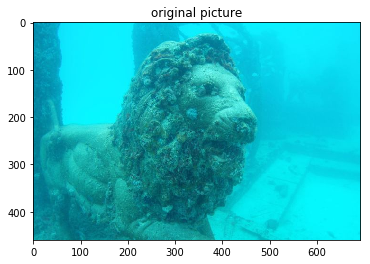

In [17]:
p = cv2.imread('cam1.png',3)
RGB_im = np.float32(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))/255
plt.imshow(RGB_im)
plt.title('original picture')
plt.show()

Here we convert the values to float 32, so we have higher precision when performing the different operations later.
After that, we convert the image to YUV color enconding space. YUV stands for luma (Y) component and two chrominance (UV) components. The filter will be applied to the luma component, as we want to perform the corrections in the luminance.

In [18]:
img = np.float32(p)
img = img/255
        
img  = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

y = img[:, :, 0]
u = img[:, :, 1]
v = img[:, :, 2]

In [19]:
rows,cols = y.shape
rh, rl, cutoff = 2.5,0.5,32
rows,cols

(460, 692)

Homomorphic filtering improves the image by simultaneous intensity range compression (illumination) and contrast enhancement (reflection).
The image is modelled according to:

$m(x,y) = i(x,y) \bullet r(x,y)$

Where:

m = image,
i = illumination,
r = reflectance.


We have to convert the image to the frequency domain in order to apply a high pass filter. In order to simplify the calculation, we use logarithms to have the product expressed as a sum:

$\ln(m(x,y)) = \ln(i(x,y)) + \ln(r(x,y))$

## Logarithm function

The logarithm of each pixel of the image is computed.
We can compute it with numpy, which is optimized for array operations, and math, which takes a single value and thus will require a for loop. Scipy also has the logarithm function, however it requires square matrix as input values.

We will compare the performance of each library with some custom approximations to the logarithm function.

### Numpy

In [20]:
%timeit y_log = np.log(y+0.01)

100 loops, best of 3: 7.58 ms per loop


### Math

In [21]:
%%%timeit
y_log2 = []
for el in y:
    for pix in el:
        y_log2.append(math.log(pix+0.01))

1 loop, best of 3: 1.14 s per loop


### Scipy

Requires square functions, we divide the img in squares

In [22]:
shape = y.shape
minval = np.amin(shape)
y_copy = y[0:minval,0:minval]
print y_copy.shape

(460, 460)


In [23]:
%timeit y_log3 = scipy.linalg.logm(y_copy)

logm result may be inaccurate, approximate err = 5.94991351345e-06
logm result may be inaccurate, approximate err = 5.94991351345e-06
logm result may be inaccurate, approximate err = 5.94991351345e-06
logm result may be inaccurate, approximate err = 5.94991351345e-06
1 loop, best of 3: 3.56 s per loop


As we have seen, numpy is the faster library for logarithm computation of an array, as it is optimized for that purpose. We will see however if we can do an approximation to the logarithm, which performs a faster computation with a small error

### Taylor Series approximation

Taylor series is a representation of a function as an infinite sum of terms that are calculated from the values of the function's derivatives at a single point.
The Taylor Serie of the natural logarithm used here is:

$ln(x) = \sum^\infty_{n=1} \frac{(-1)^{n+1}}{n}(x-1)^n  \cong (x-1) - \frac{(x-1)^2}{2} - \frac{(x-1)^3}{3} - ...$


For $|x|<1$. Firt we check that we accomplish that condition:

In [24]:
print np.amax(y)

0.83651


In [25]:
%%%timeit
x = y+0.01
log = (x-1) - (x-1)**2/2 + (x-1)**3/3

10 loops, best of 3: 31.4 ms per loop


As we can see it is quite slow. Lets check error however:

In [26]:
y_log = np.log(y+0.01)

x = y+0.01
log = (x-1) - (x-1)**2/2 + (x-1)**3/3

A = log
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

mean squared error = 0.00384542
error percentage = 0.287101497761 %


We have a bad performance as the algorithm is slow and the error is high.

### Limit Approximation

The logarithm function can be expressed as a limit according to:


$ \ln(x) = \lim\limits_{n \to \infty}n(x^{1/n}-1)$

In [27]:
def lnlm(x):
    n = 10000.0
    x = np.asarray(x)
    return n * ((x ** (1/n)) - 1)

In [28]:
%%%timeit
n = 10000
limlog = n* ((y ** (1/n)) - 1)

1000 loops, best of 3: 308 µs per loop


In [29]:
y_log = np.log(y+0.01)

limlog = lnlm(y+0.01)

print y_log[100][100]
print limlog[100][100]

A = limlog
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

-0.379333
-0.379086
mean squared error = 3.12819e-08
error percentage = 1.82610567693e-06 %


In [30]:
# time comparison
limtime   = 781.0*10**(-3) #ms
numpytime = 15.2

print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 94.8618421053 %


As we can see the error is as small as a 8.87383e-09 %, and the time performance is increased by a 95%, making the limit approximation the best option for logarithm computing

## Fourier transform

Up to this point we have the image expressed as a logarithm.

$\ln(m(x,y)) = \ln(i(x,y)) + \ln(r(x,y))$

Now we want to express it on the frequency domain, for what we will apply the Fourier transform:

$\mathcal{F}(\ln(m(x,y))) = \mathcal{F}(\ln(i(x,y))) + \mathcal{F}(\ln(r(x,y)))$

which is also expressed as:

$M(u,v) = I(u,v) + R(u,v)$

Help with this in https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
theory http://www.lip.uns.edu.ar/pdi/32.htm

We have two libraries which we can use to compute the 2D Fourier Transform: Numpy and OpenCV. Both compute this transform with a fast algorithm called Fast Fourier Transform (FFT). Both libraries return the result with the zero frequency component at the top left component, which can be brought to center with the numpy function fftshift. The magnitude spectrum will be drawn in both cases to see the similarity between both results.

### Without DFT Optimization

The DFT is optimized for array sizes which are power of two, for what we can resize the image to accomplish this requirement. We first perform the calculation with both libraries without the optimization, and then with the optimization to compare results.

#### Numpy

In [31]:
%%%timeit
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

10 loops, best of 3: 92.9 ms per loop


In [32]:
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

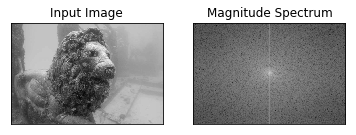

In [33]:
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

##### OpenCV

In [34]:
%%%timeit
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 6.09 ms per loop


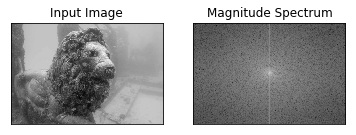

In [35]:
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum2 = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum2, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

error

In [36]:
A = magnitude_spectrum
print A.shape
B = magnitude_spectrum2
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(460, 692)
(460, 692)
45.5112247172
45.5113
mean squared error = 1.22962216602e-07
error percentage = 1.53021732779e-07 %


As we can see the result is basically the same, with OpenCV being much more faster. Let's see how much the optimization improves the time performance.

### With DFT optimization

First, obtain optimal size of the image, and then generate a new image with this size where we fill the extra pixels with zero values.

In [37]:
rows,cols = limlog.shape
print rows,cols

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print nrows, ncols

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

460 692
480 720


##### Numpy

In [38]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

10 loops, best of 3: 44.9 ms per loop


In [39]:
fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

##### OpenCV

In [40]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

100 loops, best of 3: 14.2 ms per loop


In [41]:
dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

In [42]:
A = magnitude_spectrum4
print A.shape
B = magnitude_spectrum3
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(480, 720)
(480, 720)
49.8783370659
49.8783
mean squared error = 4.55754895188e-08
error percentage = 5.62867036052e-08 %


In [43]:
# time comparison
opencvtime   = 29.9 #ms
numpytime    = 793
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 99.9015132409 %


Numpy and OpenCV return basically the same value, as the error is very small. However, the performance of OpenCV with the optimization is significativally better than that of numpy (without optimization)

### High pass filter

Now that we have the image in the frequency domain, the next step is to apply the high pass filter. To make the illumination of an image more even, the high-frequency components are increased and low-frequency components are decreased. 

$N(u,v) = H(u,v) \bullet M(u,v)$

Where

H = High-pass filter,
N = Filtered image in the frequency domain.

#### Custom High Pass filter

This filter decreases the contribution of the low frequencies (illumination) and amplifies the contribution of mid and high frequencies (reflectance), sharpening the edges in the image, as seen in "Automatic Underwater Image Pre-Processing" by Stéphane Bazeille et al.

$H(u,v) = (r_H-r_L)(1-\exp(-\frac{u^2+v^2}{2\delta^2}))+r_L$

where $r_H = 2.5$ and $r_L=0.5$ are the maximum and minimum coefficients values and $\delta$ a factor which controls the cutoff frequency. They are selected empirically.

In [44]:
DX = ncols/cutoff
G = np.ones((nrows,ncols))

##### Numpy

This is what the most "intuitive" function to generate the filter takes.
We first focus on the exponential function. Numpy has a function which computes the exponential, but the built-in operations on arrays from numpy also allow to do the operation "manually". Let's check both options:

In [45]:
%%%timeit
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=((rh-rl)*(1-np.exp(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))))+rl

result_filter = G * fshift2

1 loop, best of 3: 1.67 s per loop


In [46]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 598 ms per loop


#### Taylor Approximation

The taylor series of the exponential function converges for all x, and is expressed as:


$e^x = \sum^{\infty}_{n=0}\frac{x^n}{n!} = 1 + x + \frac{x^2}{2!}+ \frac{x^3}{3!}$

In [47]:
def exp_taylor(x):
    return 1+x+x**2/2+x**3/3+x**4/24+x**5/120+x**6/720+x**7/5040

print np.e**5
print exp_taylor(5)

148.413159103
147


In [48]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_taylor(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 1 s per loop


Due to this high error, we discard the Taylor series for exponential function approximation. It is also slower than the numpy function.

##### Limit Approximation

The exponential function can be obtaind as the limit of a sequence according to:
$ e^x = \lim\limits_{n \to \infty} (1+\frac{x}{n})^n $

In [49]:
def exp_lim(x):
    n = 10000
    return (1+x/n)**n

print np.e**5
print exp_lim(5.0)

148.413159103
148.227820292


In [50]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_lim(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 678 ms per loop


##### Code Optimization

Since there is no use of libraries here, the only option to improve the performance is to optimize the code.

In [51]:
%%%timeit
G = []
G = [(i,j) for i in range (nrows) for j in range (ncols)]
H = map(lambda x: exp_lim(-(x[0]**2+x[1]**2)/(2*DX**2)), G)
H = 1-np.asarray(H)
H = H*(rh-rl)
H = H +rl

1 loop, best of 3: 557 ms per loop


Here we use list comprehension, which is the fastest iteration tool that Python provides:

In [52]:
%%%timeit
G = []
G = [exp_lim(-(i**2+j**2)/(2*DX**2)) for i in range (nrows) for j in range (ncols)]
H = 1-np.asarray(G)
H = H*(rh-rl)
H = H +rl

1 loop, best of 3: 356 ms per loop


We have also experimentally seen that the more operations we take out of the loop, the faster the algorithm.
Also, if we perform all the operations in the same line command instead of calling a function, the computation time decreases significativally:

In [53]:
%%%timeit
G = []
n = 10000
G = [(-(i**2+j**2)) for i in range (nrows) for j in range (ncols)]
H = np.asarray(G)/(2*DX**2)
H = H/n
H = (1-(1+H)**n)
H = H*(rh-rl)
H = H +rl
H = np.reshape(H,(nrows,ncols))

1 loop, best of 3: 230 ms per loop


In resume, and as seen here (https://medium.freecodecamp.org/if-you-have-slow-loops-in-python-you-can-fix-it-until-you-cant-3a39e03b6f35):
   - Do numerical calculations with NumPy functions. They are two orders of magnitude faster than Python’s built-in tools.
   - Of Python’s built-in tools, list comprehension is faster than map() , which is significantly faster than for.
   - For deeply recursive algorithms, loops are more efficient than recursive function calls.
   - “Dumb” code (broken down into elementary operations) is the slowest. Use built-in functions and tools.


In [55]:
G = np.ones((nrows,ncols))
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G*(rh-rl)
G = G +rl

A = G

F = []
n = 100000.0
F = [(-((i-nrows/2)**2+(j-ncols/2)**2)) for i in range (nrows) for j in range (ncols)]
H = np.asarray(F,dtype=np.float64)/(2.0*DX**2)
H = H/n
H = (1-(1+H)**n)
H = H*(rh-rl)
H = H +rl
H = np.reshape(H,(nrows,ncols))



print A.shape
B = H
print B.shape

print A[400][200]
print B[400][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(480, 720)
(480, 720)
2.5
2.5
mean squared error = 0.00416915308646
error percentage = 0.833830617292 %


In [57]:
print fshift2[400][200]
print G[400][200]
print H[400][200]
result_filter1 = G * fshift2

result_filter2 = H * fshift2

A = result_filter1
print A.shape
B = result_filter2
print B.shape

print A[400][200]
print B[400][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(4.47728691237+5.24748252823j)
2.5
2.5
(480, 720)
(480, 720)
(11.1932172809+13.1187063206j)
(11.1932172809+13.1187063206j)
mean squared error = (3979.9239529-4.78890640631e-11j)
error percentage = (3.74328122099-4.50416229857e-14j) %


In [58]:
# time comparison
opttime   = 3.26*10**3 #ms
numpytime    = 418
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 99.8131578947 %


#### With OpenCV array

I perform the same operations but with the Fourier transform obained from the OpenCV functions. I need to convert the two-channel opencv array to one-channel with complex numbers

In [59]:
dft_complex = dft_shift2[:,:,1] + dft_shift2[:,:,0]*1j

In [60]:
%timeit dft_complex = dft_shift2[:,:,1] + dft_shift2[:,:,0]*1j

The slowest run took 4.69 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.72 ms per loop


In [62]:
A = fshift2
B = dft_complex


print A[400][200]
print B[400][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(4.47728691237+5.24748252823j)
(4.47728+5.24748j)
mean squared error = (6.86024567773e-10+2.36783082795e-11j)
error percentage = (3.22617079129e-13+1.1135208584e-14j) %


In [63]:
print G[400][200]
print H[400][200]
result_filter3 = G * dft_complex

result_filter4 = H * dft_complex

A = result_filter2
print A.shape
B = result_filter4
print B.shape

print A[400][200]
print B[400][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

2.5
2.5
(480, 720)
(480, 720)
(11.1932172809+13.1187063206j)
(11.1932063103+13.1187033653j)
mean squared error = (3.9528463054e-09+5.98804073773e-11j)
error percentage = (3.71781358629e-12+5.63199717114e-14j) %


#### Simple High pass filter

Here we will simply suppress all the lower frequencies.They are allocated in the center, so we can simply turn the first elements of the matrix to zero. The size of the window is selected manually.

In [64]:
%%%timeit
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-15:crow+15, ccol-15:ccol+15,0] = 0
dft_shift2_copy[crow-15:crow+15, ccol-30:ccol+15,1] = 0

1000 loops, best of 3: 220 µs per loop


In [65]:
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-2:crow+2, ccol-2:ccol+2,0] = 0
dft_shift2_copy[crow-2:crow+2, ccol-2:ccol+2,1] = 0

## Inverse Fourier Transform

Once the filter is applied, we return back to the spatial domain by using a inverse Fourier transform.

$n(x,y) = inv\mathcal{F}(N(u,v))$

### Numpy

In [66]:
%timeit result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter4)))

10 loops, best of 3: 27.5 ms per loop


In [67]:
result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter4)))


### OpenCV

According to OpenCV documentation on the cv2.idft function: http://docs.opencv.org/modules/core/doc/operations_on_arrays.html#idft . There is a note at the end of it, which says:

    Note: None of dft and idft scales the result by default. So, you should pass DFT_SCALE to one of dft or idft explicitly to make these transforms mutually inverse.

So, when calling idft, it is necessary to pass the cv2.DFT_SCALE flag. 

In [68]:
idft_flags = cv2.DFT_COMPLEX_OUTPUT| cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT

In [69]:
%%%timeit
result_split = np.ndarray(dft_shift2.shape)
result_split[:,:,0] = result_filter4.imag
result_split[:,:,1] = result_filter4.real

result_interm2 = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)

100 loops, best of 3: 8.12 ms per loop


In [70]:
result_split = np.ndarray(dft_shift2.shape)
result_split[:,:,0] = result_filter4.imag
result_split[:,:,1] = result_filter4.real

result_interm2 = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)

In [72]:
A = result_interm
print A.shape
B = result_interm2
print B.shape

print A[400][200]
print B[400][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(480, 720)
(480, 720)
-0.644436698386
-0.644436698386


3.0532854166481417e-31

In [73]:
# time comparison
opcvtime   = 29.7 #ms
numpytime    = 40.1
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 98.0523690773 %


### OpenCV + Simple HPF

In [74]:
result_interm3 = cv2.idft(np.fft.ifftshift(dft_shift2_copy),flags = idft_flags)

## Reverse Logarithm Transform with exponential

The last step is to eliminate the logarithm with the exponential to finally obtain the enhanced image.

### Numpy

In [75]:
%timeit result = np.exp(result_interm2)

10 loops, best of 3: 13.9 ms per loop


### Limit approximation

In [76]:
%timeit result2 = exp_lim(result_interm2)

10 loops, best of 3: 27.3 ms per loop


In [77]:
result = np.exp(result_interm2)

In [78]:
result2 = exp_lim(result_interm2)

In [80]:
A = result
print A.shape
B = result2
print B.shape

print A[400][200]
print B[400][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(480, 720)
(480, 720)
0.524958168619
0.524947267543


6.3923818677434534e-11

Here the best option is to use the built-in numpy function as it is the fastest.

In [81]:
j = result[0:rows,0:cols]

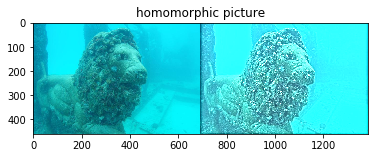

In [82]:
merged = cv2.merge((np.float32(j),u,v))
imgf  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

#### Custom Simply HPF

In [83]:
%timeit result2 = np.exp(result_interm3)

100 loops, best of 3: 9.04 ms per loop


In [84]:
result3 = np.exp(result_interm3)
#k = np.float32(result2)
k_original_size = result3[0:rows,0:cols]
k_original_size.shape

(460, 692)

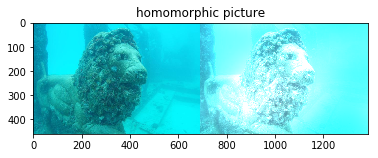

In [85]:


merged2 = cv2.merge((k_original_size,u,v))
imgf2  = cv2.cvtColor(merged2,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

In [86]:
%%%timeit
otra = homomorphic_filter(y)

1 loop, best of 3: 1.88 s per loop


In [87]:
%%%timeit
otra = fast_homomorphic_filter(y)

1 loop, best of 3: 331 ms per loop


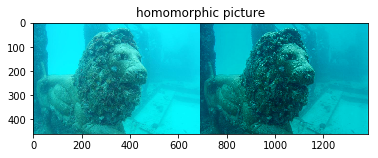

In [88]:
otra = homomorphic_filter(y)
merged = cv2.merge((otra,u,v))
imgf2  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

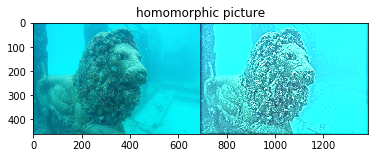

In [89]:
otra = fast_homomorphic_filter(y)
merged = cv2.merge((otra,u,v))
imgf2  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

In [90]:
# time comparison
opttime   = 4.11*10**3 #ms
oldtime    = 652
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 98.0523690773 %


# Wavelet Denoising

Wavelet denoising relies on the wavelet representation of the image. Gaussian noise tends to be represented by small values in the wavelet domain and can be removed by setting coefficients below a given threshold to zero (hard thresholding) or shrinking all coefficients toward zero by a given amount (soft thresholding).

- The BayesShrink algorithm is an adaptive approach to wavelet soft thresholding where a unique threshold is estimated for each wavelet subband. This generally results in an improvement over what can be obtained with a single threshold.
- The VisuShrink approach employs a single, universal threshold to all wavelet detail coefficients. This threshold is designed to remove additive Gaussian noise with high probability, which tends to result in overly smooth image appearance. By specifying a sigma that is smaller than the true noise standard deviation, a more visually agreeable result can be obtained.

In [93]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [94]:
y_img = otra

Estimate the average noise standard deviation across color channels.

In [95]:
sigma_est = estimate_sigma(y_img, multichannel=True, average_sigmas=True)

Due to clipping in random_noise, the estimate will be a bit smaller than the specified sigma.

In [96]:
print("Estimated Gaussian noise standard deviation = {}".format(sigma_est))

Estimated Gaussian noise standard deviation = 0.021612869419


In [97]:
im_bayes = denoise_wavelet(y_img, multichannel=False, convert2ycbcr=False,
                           method='BayesShrink', mode='soft')
im_visushrink = denoise_wavelet(y_img, multichannel=False, convert2ycbcr=False,
                                method='VisuShrink', mode='soft',
                                sigma=sigma_est)

VisuShrink is designed to eliminate noise with high probability, but this results in a visually over-smooth appearance.  Repeat, specifying a reduction in the threshold by factors of 2 and 4.

In [98]:
im_visushrink2 = denoise_wavelet(y_img, multichannel=False, convert2ycbcr=False,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/2)
im_visushrink4 = denoise_wavelet(y_img, multichannel=False, convert2ycbcr=False,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/4)


Compute PSNR as an indication of image quality

In [99]:
psnr_noisy = 0
psnr_bayes = compare_psnr(y_img/255, im_bayes)
psnr_visushrink = compare_psnr(y_img/255, im_visushrink)
psnr_visushrink2 = compare_psnr(y_img/255, im_visushrink2)
psnr_visushrink4 = compare_psnr(y_img/255, im_visushrink4)


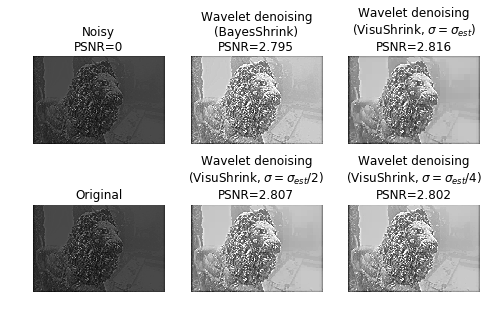

In [100]:
plt.rcParams['figure.figsize'] = [20,10]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5),
                       sharex=True, sharey=True)

ax[0, 0].imshow(y_img, cmap = 'gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy\nPSNR={:0.4g}'.format(psnr_noisy))
ax[0, 1].imshow(im_bayes, cmap = 'gray')
ax[0, 1].axis('off')
ax[0, 1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0, 2].imshow(im_visushrink, cmap = 'gray')
ax[0, 2].axis('off')
ax[0, 2].set_title(
    ('Wavelet denoising\n(VisuShrink, $\sigma=\sigma_{est}$)\n'
     'PSNR=%0.4g' % psnr_visushrink))
ax[1, 0].imshow(y_img, cmap = 'gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')
ax[1, 1].imshow(im_visushrink2, cmap = 'gray')
ax[1, 1].axis('off')
ax[1, 1].set_title(
    ('Wavelet denoising\n(VisuShrink, $\sigma=\sigma_{est}/2$)\n'
     'PSNR=%0.4g' % psnr_visushrink2))
ax[1, 2].imshow(im_visushrink4, cmap = 'gray')
ax[1, 2].axis('off')
ax[1, 2].set_title(
    ('Wavelet denoising\n(VisuShrink, $\sigma=\sigma_{est}/4$)\n'
     'PSNR=%0.4g' % psnr_visushrink4))


plt.show()

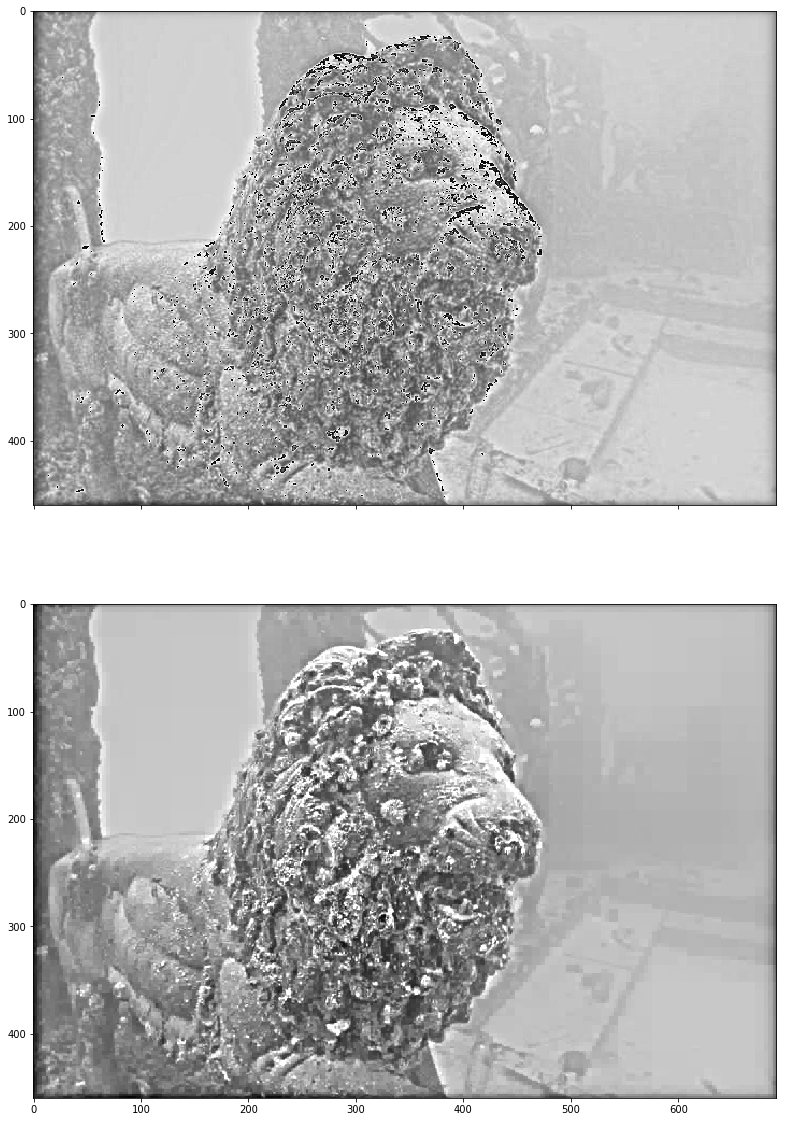

In [101]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 20),
                       sharex=True, sharey=True)
ax[0].imshow(np.uint8(y_img*255), cmap = 'gray')
ax[1].imshow(im_visushrink2, cmap = 'gray')
plt.show()

In [102]:
def wavelet_denoise(img):
    sigma_est = estimate_sigma(img, multichannel=False, average_sigmas=True)
    im_bayes = denoise_wavelet(img, multichannel=False, convert2ycbcr=False,
                           method='VisuShrink', mode='soft',sigma=sigma_est)
    return im_bayes
    

In [103]:
%timeit wavelet_denoise(y_img)

10 loops, best of 3: 19 ms per loop


In [104]:
%timeit dst = cv2.fastNlMeansDenoising(np.uint8(y_img*255),dst = None,h=7,templateWindowSize=2,searchWindowSize=7)

10 loops, best of 3: 93.6 ms per loop


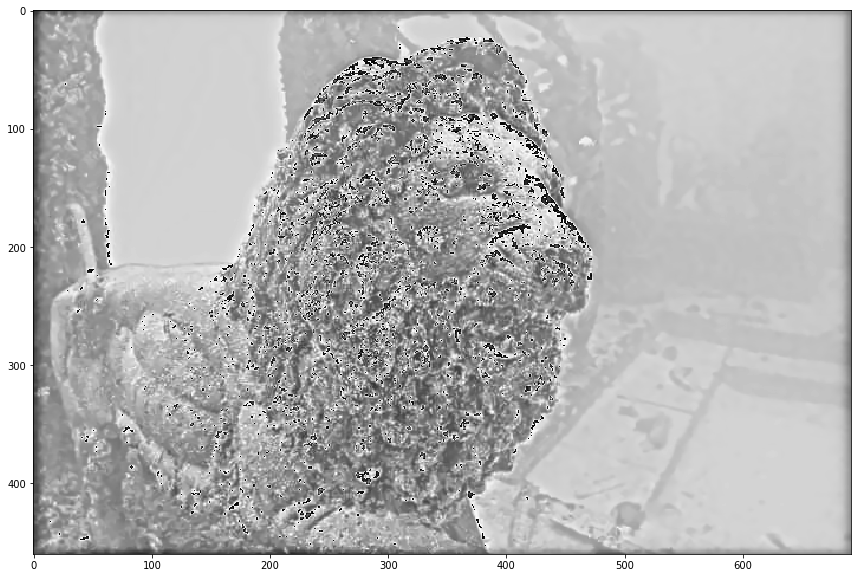

In [107]:
fastnl = cv2.fastNlMeansDenoising(np.uint8(y_img*255),dst = None,h=7,templateWindowSize=2,searchWindowSize=7)
plt.imshow(fastnl, cmap = 'gray')
plt.show()

# Median Blur

In [108]:
%timeit cv2.medianBlur(y_img,5)

100 loops, best of 3: 2.23 ms per loop


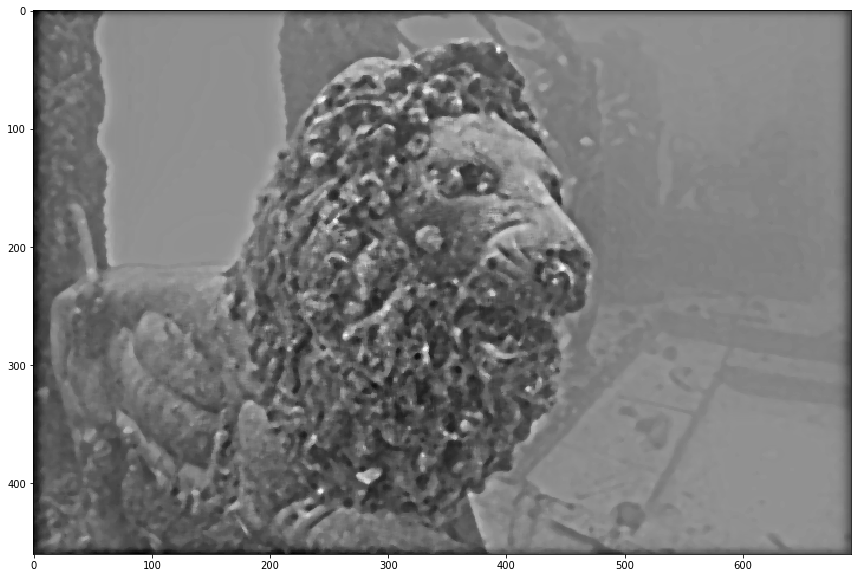

In [109]:
median = cv2.medianBlur(y_img,5)
plt.imshow(median, cmap = 'gray')
plt.show()

# Bilateral Filtering

cv2.bilateralFilter() is highly effective in noise removal while keeping edges sharp. But the operation is slower compared to other filters. 
Bilateral filter also takes a gaussian filter in space, but one more gaussian filter which is a function of pixel difference. Gaussian function of space make sure only nearby pixels are considered for blurring while gaussian function of intensity difference make sure only those pixels with similar intensity to central pixel is considered for blurring. So it preserves the edges since pixels at edges will have large intensity variation.

In [110]:
%timeit blur = cv2.bilateralFilter(np.uint8(y_img*255),5,200,200)

100 loops, best of 3: 5.38 ms per loop


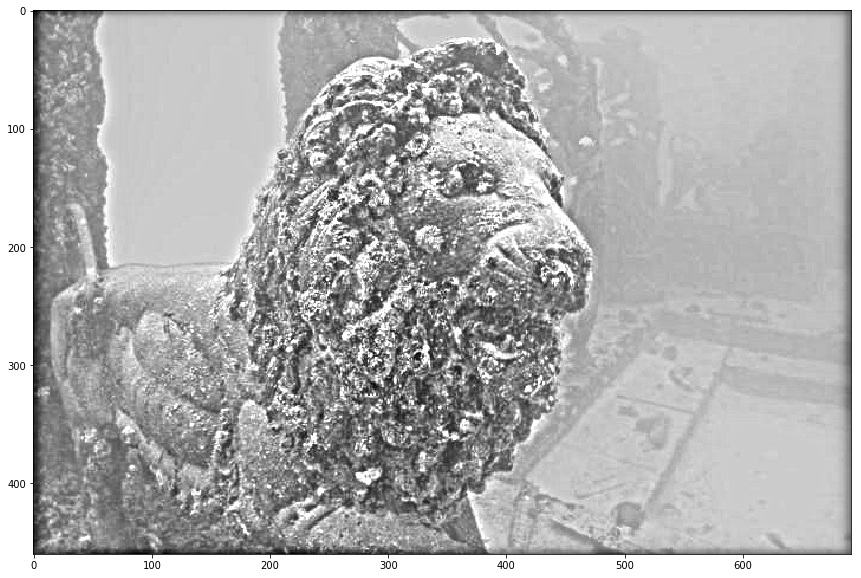

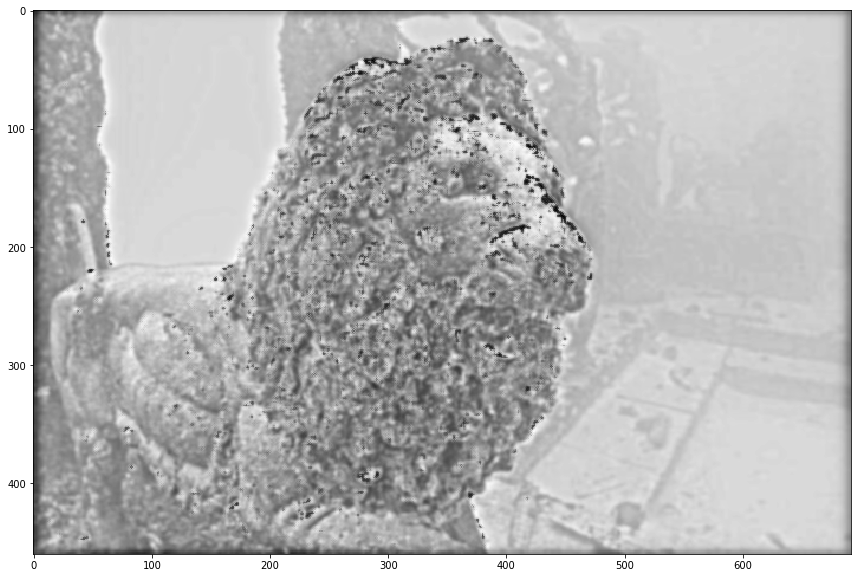

In [111]:
blur = cv2.bilateralFilter(np.uint8(y_img*255),5,200,200)
plt.imshow(im_bayes, cmap = 'gray')
plt.show()
plt.imshow(blur, cmap = 'gray')
plt.show()

# Anisotropic Filtering

In [112]:
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,ploton=False):
        """
        Anisotropic diffusion.
 
        Usage:
        imgout = anisodiff(im, niter, kappa, gamma, option)
 
        Arguments:
                img    - input image
                niter  - number of iterations
                kappa  - conduction coefficient 20-100 ?
                gamma  - max value of .25 for stability
                step   - tuple, the distance between adjacent pixels in (y,x)
                option - 1 Perona Malik diffusion equation No 1
                         2 Perona Malik diffusion equation No 2
                ploton - if True, the image will be plotted on every iteration
 
        Returns:
                imgout   - diffused image.
 
        kappa controls conduction as a function of gradient.  If kappa is low
        small intensity gradients are able to block conduction and hence diffusion
        across step edges.  A large value reduces the influence of intensity
        gradients on conduction.
 
        gamma controls speed of diffusion (you usually want it at a maximum of
        0.25)
 
        step is used to scale the gradients in case the spacing between adjacent
        pixels differs in the x and y axes
 
        Diffusion equation 1 favours high contrast edges over low contrast ones.
        Diffusion equation 2 favours wide regions over smaller ones.
 
        Reference:
        P. Perona and J. Malik.
        Scale-space and edge detection using ansotropic diffusion.
        IEEE Transactions on Pattern Analysis and Machine Intelligence,
        12(7):629-639, July 1990.
 
        Original MATLAB code by Peter Kovesi  
        School of Computer Science & Software Engineering
        The University of Western Australia
        pk @ csse uwa edu au
        <http://www.csse.uwa.edu.au>
 
        Translated to Python and optimised by Alistair Muldal
        Department of Pharmacology
        University of Oxford
        <alistair.muldal@pharm.ox.ac.uk>
 
        June 2000  original version.      
        March 2002 corrected diffusion eqn No 2.
        July 2012 translated to Python
        """
 
        # ...you could always diffuse each color channel independently if you
        # really want
        if img.ndim == 3:
                warnings.warn("Only grayscale images allowed, converting to 2D matrix")
                img = img.mean(2)
 
        # initialize output array
        img = img.astype('float32')
        imgout = img.copy()
 
        # initialize some internal variables
        deltaS = np.zeros_like(imgout)
        deltaE = deltaS.copy()
        NS = deltaS.copy()
        EW = deltaS.copy()
        gS = np.ones_like(imgout)
        gE = gS.copy()
 
        # create the plot figure, if requested
        if ploton:
                import pylab as pl
                from time import sleep
 
                fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
                ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
 
                ax1.imshow(img,interpolation='nearest')
                ih = ax2.imshow(imgout,interpolation='nearest',animated=True, cmap = 'gray')
                ax1.set_title("Original image")
                ax2.set_title("Iteration 0")
 
                fig.canvas.draw()
 
        for ii in xrange(niter):
 
                # calculate the diffs
                deltaS[:-1,: ] = np.diff(imgout,axis=0)
                deltaE[: ,:-1] = np.diff(imgout,axis=1)
 
                # conduction gradients (only need to compute one per dim!)
                if option == 1:
                        gS = np.exp(-(deltaS/kappa)**2.)/step[0]
                        gE = np.exp(-(deltaE/kappa)**2.)/step[1]
                elif option == 2:
                        gS = 1./(1.+(deltaS/kappa)**2.)/step[0]
                        gE = 1./(1.+(deltaE/kappa)**2.)/step[1]
 
                # update matrices
                E = gE*deltaE
                S = gS*deltaS
 
                # subtract a copy that has been shifted 'North/West' by one
                # pixel. don't as questions. just do it. trust me.
                NS[:] = S
                EW[:] = E
                NS[1:,:] -= S[:-1,:]
                EW[:,1:] -= E[:,:-1]
 
                # update the image
                imgout += gamma*(NS+EW)
 
                if ploton:
                        iterstring = "Iteration %i" %(ii+1)
                        ih.set_data(imgout)
                        ax2.set_title(iterstring)
                        fig.canvas.draw()
                        # sleep(0.01)
 
        return imgout

In [113]:
def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):
        """
        3D Anisotropic diffusion.
 
        Usage:
        stackout = anisodiff(stack, niter, kappa, gamma, option)
 
        Arguments:
                stack  - input stack
                niter  - number of iterations
                kappa  - conduction coefficient 20-100 ?
                gamma  - max value of .25 for stability
                step   - tuple, the distance between adjacent pixels in (z,y,x)
                option - 1 Perona Malik diffusion equation No 1
                         2 Perona Malik diffusion equation No 2
                ploton - if True, the middle z-plane will be plotted on every
                         iteration
 
        Returns:
                stackout   - diffused stack.
 
        kappa controls conduction as a function of gradient.  If kappa is low
        small intensity gradients are able to block conduction and hence diffusion
        across step edges.  A large value reduces the influence of intensity
        gradients on conduction.
 
        gamma controls speed of diffusion (you usually want it at a maximum of
        0.25)
 
        step is used to scale the gradients in case the spacing between adjacent
        pixels differs in the x,y and/or z axes
 
        Diffusion equation 1 favours high contrast edges over low contrast ones.
        Diffusion equation 2 favours wide regions over smaller ones.
 
        Reference:
        P. Perona and J. Malik.
        Scale-space and edge detection using ansotropic diffusion.
        IEEE Transactions on Pattern Analysis and Machine Intelligence,
        12(7):629-639, July 1990.
 
        Original MATLAB code by Peter Kovesi  
        School of Computer Science & Software Engineering
        The University of Western Australia
        pk @ csse uwa edu au
        <http://www.csse.uwa.edu.au>
 
        Translated to Python and optimised by Alistair Muldal
        Department of Pharmacology
        University of Oxford
        <alistair.muldal@pharm.ox.ac.uk>
 
        June 2000  original version.      
        March 2002 corrected diffusion eqn No 2.
        July 2012 translated to Python
        """
 
        # ...you could always diffuse each color channel independently if you
        # really want
        if stack.ndim == 4:
                warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
                stack = stack.mean(3)
 
        # initialize output array
        stack = stack.astype('float32')
        stackout = stack.copy()
 
        # initialize some internal variables
        deltaS = np.zeros_like(stackout)
        deltaE = deltaS.copy()
        deltaD = deltaS.copy()
        NS = deltaS.copy()
        EW = deltaS.copy()
        UD = deltaS.copy()
        gS = np.ones_like(stackout)
        gE = gS.copy()
        gD = gS.copy()
 
        # create the plot figure, if requested
        if ploton:
                import pylab as pl
                from time import sleep
 
                showplane = stack.shape[0]//2
 
                fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
                ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)
 
                ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
                ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
                ax1.set_title("Original stack (Z = %i)" %showplane)
                ax2.set_title("Iteration 0")
 
                fig.canvas.draw()
 
        for ii in xrange(niter):
 
                # calculate the diffs
                deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
                deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
                deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)
 
                # conduction gradients (only need to compute one per dim!)
                if option == 1:
                        gD = np.exp(-(deltaD/kappa)**2.)/step[0]
                        gS = np.exp(-(deltaS/kappa)**2.)/step[1]
                        gE = np.exp(-(deltaE/kappa)**2.)/step[2]
                elif option == 2:
                        gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
                        gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
                        gE = 1./(1.+(deltaE/kappa)**2.)/step[2]
 
                # update matrices
                D = gD*deltaD
                E = gE*deltaE
                S = gS*deltaS
 
                # subtract a copy that has been shifted 'Up/North/West' by one
                # pixel. don't as questions. just do it. trust me.
                UD[:] = D
                NS[:] = S
                EW[:] = E
                UD[1:,: ,: ] -= D[:-1,:  ,:  ]
                NS[: ,1:,: ] -= S[:  ,:-1,:  ]
                EW[: ,: ,1:] -= E[:  ,:  ,:-1]
 
                # update the image
                stackout += gamma*(UD+NS+EW)
 
                if ploton:
                        iterstring = "Iteration %i" %(ii+1)
                        ih.set_data(stackout[showplane,...].squeeze())
                        ax2.set_title(iterstring)
                        fig.canvas.draw()
                        # sleep(0.01)
 
        return stackout

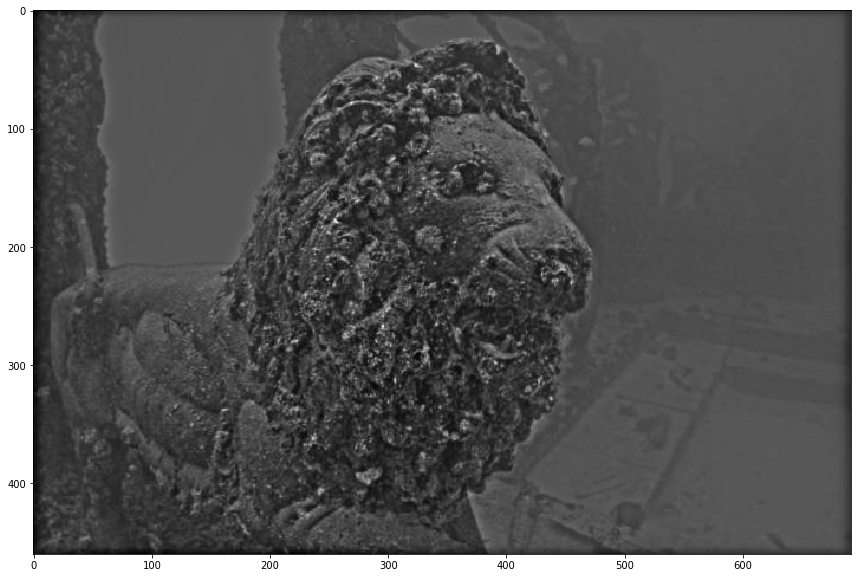

In [114]:
anidif = anisodiff(y_img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,ploton=False)
plt.imshow(anidif, cmap = 'gray')
plt.show()

In [116]:
%timeit anidif = anisodiff(y_img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,ploton=False)

10 loops, best of 3: 25.4 ms per loop


# Contrast Stretching

In [117]:
def contrast_stretch(img):
    min = np.amin(img)
    max = np.amax(img)
    img = (img-min)/(max-min)
    #for channel in img:
     #   for _ in channel:
      #      for pix in _:
     #           if pix > 1 :
      #              pix = 1
      #          elif pix < 0 :
      #              pix = 0
      #          else:
       #             pix = (pix-min)/(max-min)
    return img

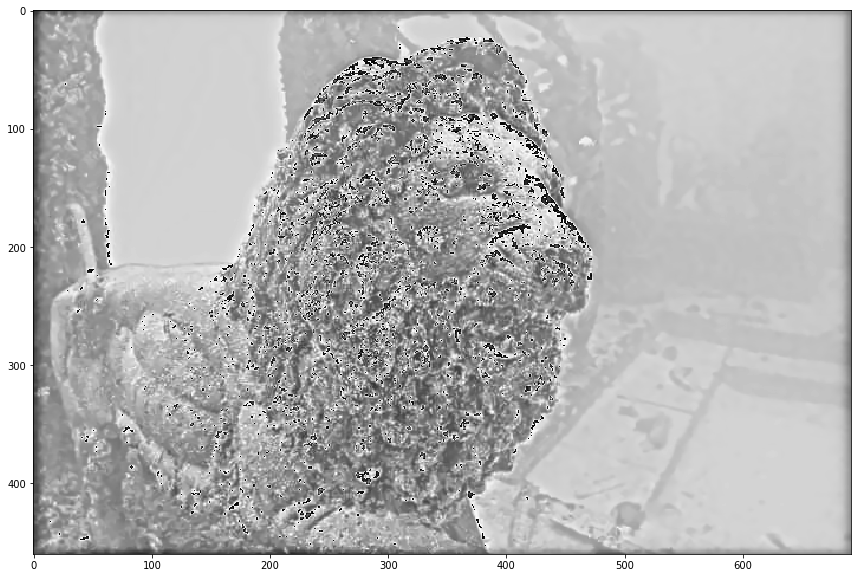

In [118]:
contrasted = contrast_stretch(np.float32(fastnl))
plt.imshow(contrasted, cmap = 'gray')
plt.show()

In [126]:
r = contrasted[:, :, 0]
g = contrasted[:, :, 1]
b = contrasted[:, :, 2]

equr = cv2.equalizeHist(np.uint8(r))
equg = cv2.equalizeHist(np.uint8(g))
equb = cv2.equalizeHist(np.uint8(b))

equalized = cv2.merge((equr,equg,equb))
plt.imshow(equalized)
plt.show()

IndexError: too many indices for array

# Feature Detection

## SIFT

In [149]:
%%%timeit
sift = cv2.xfeatures2d.SIFT_create()
kp, descs = sift.detectAndCompute(fastnl,None)

1 loop, best of 3: 309 ms per loop


# kps: 3180, descriptors: (3180, 128)


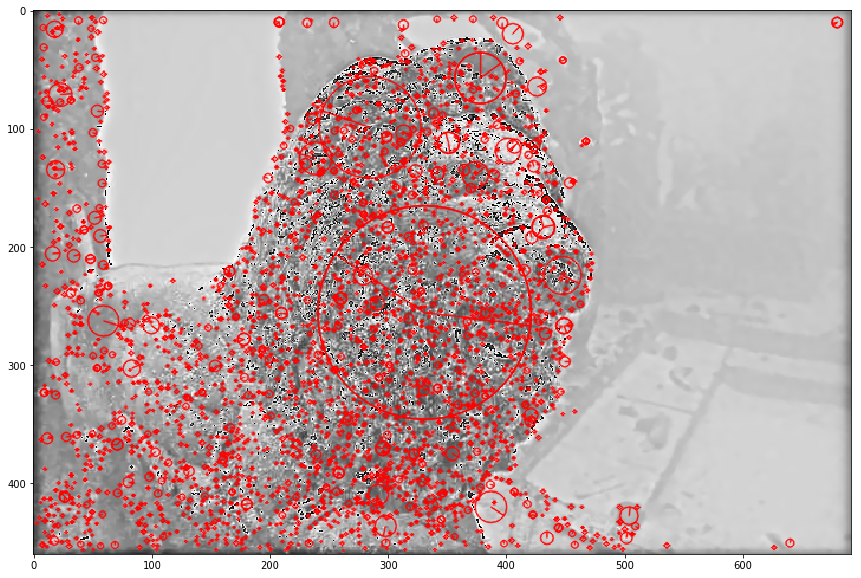

In [146]:
sift = cv2.xfeatures2d.SIFT_create()
kp, descs = sift.detectAndCompute(fastnl,None)
print("# kps: {}, descriptors: {}".format(len(kp), descs.shape))
img=cv2.drawKeypoints(fastnl,kp,None,(255,0,0),4)

plt.imshow(img)
plt.show()

## SURF

In [150]:
%%%timeit
surf = cv2.xfeatures2d.SURF_create(400)
kp, des = surf.detectAndCompute(fastnl,None)

1 loop, best of 3: 257 ms per loop


# kps: 2223, descriptors: (2223, 64)


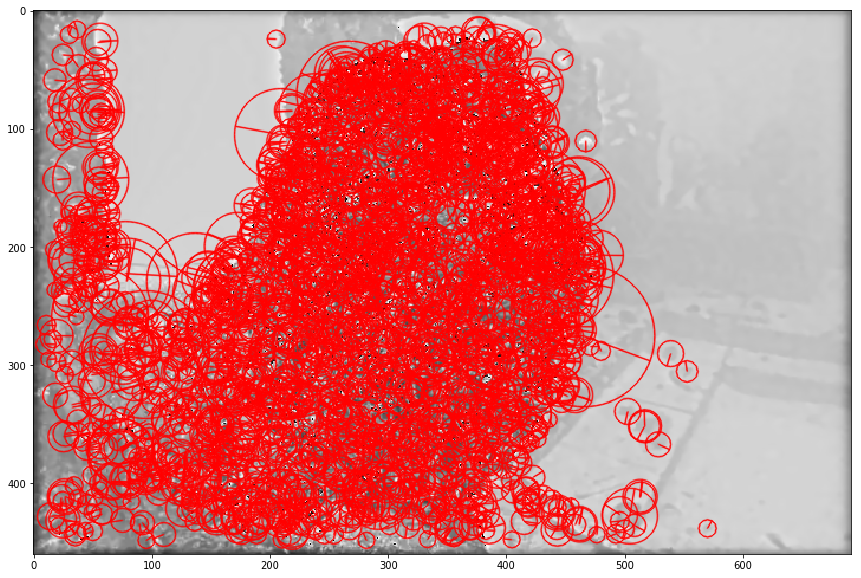

In [147]:
surf = cv2.xfeatures2d.SURF_create(400)
kp, des = surf.detectAndCompute(fastnl,None)
print("# kps: {}, descriptors: {}".format(len(kp), des.shape))
img2 = cv2.drawKeypoints(fastnl,kp,None,(255,0,0),4)
plt.imshow(img2)
plt.show()

## BRISK

In [159]:
%%%timeit
brisk = cv2.BRISK_create(80)
(kps, descs) = brisk.detectAndCompute(fastnl, None)

1 loop, best of 3: 376 ms per loop


# kps: 2276, descriptors: (2276, 64)


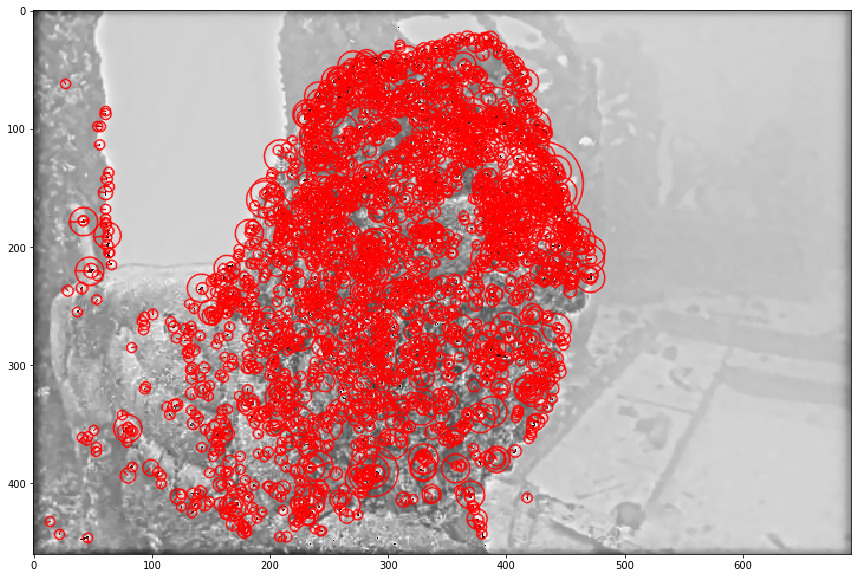

In [158]:
brisk = cv2.BRISK_create(80)
(kps, descs) = brisk.detectAndCompute(fastnl, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))
img3 = cv2.drawKeypoints(fastnl,kps,None,(255,0,0),4)
plt.imshow(img3)
plt.show()

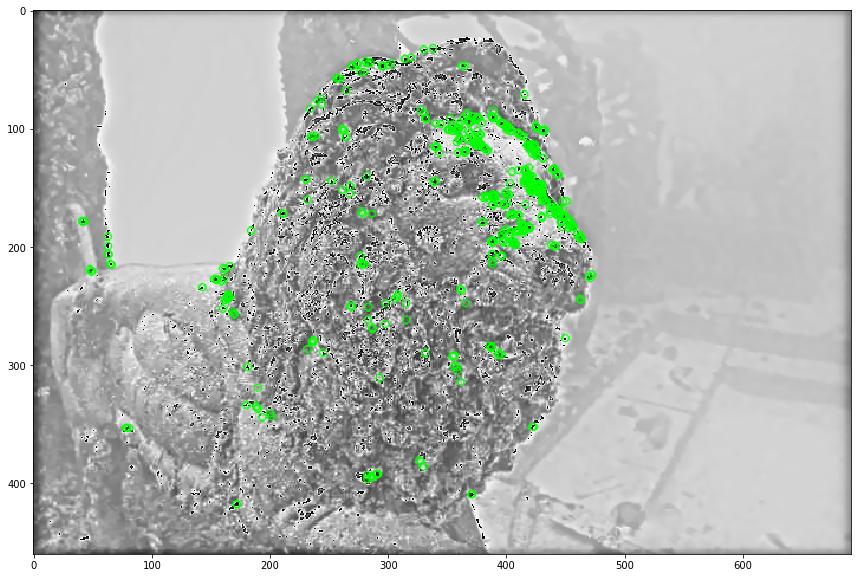

(<matplotlib.image.AxesImage at 0x7fd3baa7ffd0>, None)

In [164]:
# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp, desc = orb.detectAndCompute(fastnl,None)

# compute the descriptors with ORB
kp, des = orb.compute(fastnl, kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(fastnl,kp,None,color=(0,255,0), flags=0)
plt.imshow(img2),plt.show()


# Feature matching

# SIFT + FLANN

In [ ]:
flann = cv2.FlannBasedMatcher(index_params,search_params)